<a href="https://colab.research.google.com/github/jainanushk8/Aave-Wallet-Credit-Scoring/blob/main/Aave_Credit_Scoring_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries (if not already present in Colab)
# !pip install requests

import requests
import zipfile
import io
import json
import os

# Google Drive file ID for the compressed zip file (~10MB)
file_id = '14ceBCLQ-BTcydDrFJauVA_PKAZ7VtDor'
destination = 'aave_transactions.zip'

# Function to download file from Google Drive
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

print(f"Downloading {destination}...")
download_file_from_google_drive(file_id, destination)
print(f"Downloaded {destination}")

# Unzip the file
print(f"Unzipping {destination}...")
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('.')
print("Unzipping complete.")

# The unzipped file should be named 'transactions.json'
json_file_path = 'user-wallet-transactions.json'

# Verify the file exists
if os.path.exists(json_file_path):
    print(f"'{json_file_path}' found successfully.")
else:
    print(f"Error: '{json_file_path}' not found after unzipping.")

Downloaded aave_transactions.zip
Unzipping aave_transactions.zip...
Unzipping complete.
'user-wallet-transactions.json' found successfully.


In [2]:
# Colab Code Block 2: Load and Inspect Data (Optimized)

import pandas as pd # Import pandas for DataFrame operations
import json
import warnings

# Suppress all warnings for cleaner output in this consolidated script
warnings.filterwarnings('ignore')

json_file_path = 'user-wallet-transactions.json'

print(f"Loading '{json_file_path}' and creating DataFrame...")
try:
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    print(f"'{json_file_path}' loaded successfully. Total records: {len(data)}")

    # Convert the loaded JSON data into a Pandas DataFrame
    df = pd.DataFrame(data)
    print("DataFrame created successfully.")

    # --- Initial Data Inspection ---
    print("\n--- Initial Data Head (First 5 Rows) ---")
    print(df.head())

    print("\n--- Initial Data Info (Column types and non-null counts) ---")
    df.info()

    print("\n--- Initial Data Description (Summary statistics for numerical columns only) ---")
    print(df.describe()) # This will only describe numerical columns, which is faster

    # print("\n--- Initial Data Description (Summary statistics for all columns, including objects) ---")
    # print(df.describe(include='all')) # COMMENTED OUT: This line is very slow for large datasets with object dtypes.

    # Display a sample transaction record, especially useful for nested structures
    if not df.empty:
        print("\n--- Sample Transaction Record (First Entry, original JSON format) ---")
        # Access the original data list's first element for original JSON structure
        print(json.dumps(data[0], indent=4))
    else:
        print("DataFrame is empty. No transaction records to display.")

except FileNotFoundError:
    print(f"Error: JSON file not found at '{json_file_path}'. Please ensure the file exists.")
except json.JSONDecodeError as e:
    print(f"Error: Could not decode JSON from '{json_file_path}'. Check file format. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred during data loading or initial inspection: {e}")

Loading 'user-wallet-transactions.json' and creating DataFrame...
'user-wallet-transactions.json' loaded successfully. Total records: 100000
DataFrame created successfully.

--- Initial Data Head (First 5 Rows) ---
                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc16

In [3]:
# Colab Code Block 3 (Revised and Finalized for Features): Feature Engineering

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json

# Ensure 'data' is loaded from the previous step
if 'data' not in locals() or not data:
    print("Error: 'data' not loaded. Please run previous Colab blocks.")
    try:
        with open('transactions.json', 'r') as f:
            data = json.load(f)
        print("Data reloaded for feature engineering.")
    except FileNotFoundError:
        print("transactions.json not found. Please ensure it's unzipped and named correctly.")
        exit()

# Convert list of dictionaries to DataFrame
print("Converting data to Pandas DataFrame...")
df = pd.DataFrame(data)
print("DataFrame created.")
# print("Initial DataFrame head:")
# print(df.head()) # Commenting out to reduce output verbosity

# --- Data Cleaning and Type Conversion ---
print("Extracting values and converting types...")

# Initial extraction of raw amount and price. These will be reassigned based on action type.
df['raw_amount'] = np.nan
df['asset_price_usd'] = np.nan
df['asset_symbol_for_value'] = np.nan # New column to hold the relevant asset symbol for value calculation

# Populate raw_amount, asset_price_usd, and asset_symbol_for_value based on action type
def extract_action_data_for_value(row):
    action_data = row.get('actionData')
    action_type = row.get('action')
    if not isinstance(action_data, dict):
        return np.nan, np.nan, np.nan

    if action_type in ['deposit', 'borrow', 'repay', 'redeemunderlying']:
        amount = action_data.get('amount')
        price = action_data.get('assetPriceUSD')
        symbol = action_data.get('assetSymbol')
        return amount, price, symbol
    elif action_type == 'liquidationcall':
        # For liquidationcall, liquidator receives collateral. We'll use this value.
        amount = action_data.get('liquidatedCollateralAmount')
        price = action_data.get('collateralAssetPriceUSD') # Assuming this field exists or can be derived
        symbol = action_data.get('collateralAssetSymbol')
        # If collateralAssetPriceUSD is not available directly, we might need to use assetPriceUSD from the main record for the collateral asset.
        # For simplicity, let's assume it's directly in actionData or we default to the overall assetPriceUSD if needed.
        # IMPORTANT: Based on the provided sample, 'collateralAssetPriceUSD' is NOT there directly.
        # This is a critical missing piece. For a robust solution, you'd fetch current prices from an API or associate with historical prices.
        # For this assessment, we'll make a pragmatic choice: if price isn't explicit for collateral, we'll try to use a common price if available,
        # or acknowledge this limitation. For now, let's assume we can get it from 'assetPriceUSD' if 'assetSymbol' is 'collateralAssetSymbol'.
        # For simplicity of demonstration, let's *assume* the `assetPriceUSD` in the main transaction record is for the primary asset involved (e.g., the debt asset or the main asset of the pool), and we need a price for the *collateral*.
        # Since the sample data you provided for the initial transaction didn't include `collateralAssetPriceUSD` directly in `actionData` for `liquidationcall`,
        # and we don't have historical price feeds, we'll **only use the value for liquidation if `liquidatedCollateralAmount` and `collateralAssetSymbol` are present**.
        # If no explicit price for *collateral* is given, we will rely on the count of liquidations rather than the USD value for scoring for this specific action type.
        # This is a key interview point: you'd explain this data limitation and propose fetching external historical price data for assets.

        # For the sake of having a non-zero value where possible, let's try to make a best guess:
        # If 'liquidatedCollateralAmount' exists, we could use the 'assetPriceUSD' of the *main transaction* as a proxy if it matches the symbol.
        # However, a more accurate approach for liquidations is difficult without more data.
        # Given the problem statement's focus on "transaction-level data", let's revert to using `num_liquidations` as the primary indicator for now,
        # as `total_liquidation_usd` may be consistently zero due to data limitations within the provided sample for liquidation calls.
        # We will keep `total_liquidation_usd` but it might remain zero for most entries unless the underlying JSON structure for liquidationcall has these fields differently.
        # Let's keep the logic for value extraction for liquidations, but be aware of its potential zeroes if the input data doesn't contain the price.
        amount = action_data.get('liquidatedCollateralAmount')
        # This 'assetPriceUSD' is for the *main asset* of the transaction (e.g., what was borrowed/repaid).
        # We need the price of the *collateral*. It's not explicitly provided in the sample's actionData for liquidation.
        # So, we will use a placeholder or assume 1 if no price is specified within actionData.
        # A more robust solution would require an external price oracle or different data schema.
        price = action_data.get('collateralAssetPriceUSD', 1.0) # Assume 1.0 USD if price isn't explicitly there for collateral
        symbol = action_data.get('collateralAssetSymbol')
        return amount, price, symbol
    return np.nan, np.nan, np.nan

df[['raw_amount', 'asset_price_usd', 'asset_symbol_for_value']] = df.apply(
    lambda row: pd.Series(extract_action_data_for_value(row)), axis=1
)

df['raw_amount'] = pd.to_numeric(df['raw_amount'], errors='coerce')
df['asset_price_usd'] = pd.to_numeric(df['asset_price_usd'], errors='coerce')

# Convert 'timestamp' to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') # assuming timestamp is Unix timestamp in seconds

# Drop rows where essential conversions failed OR key data is missing for value calculation
# We'll only drop if raw_amount or asset_price_usd is NaN, or timestamp/action is missing.
df.dropna(subset=['raw_amount', 'asset_price_usd', 'timestamp', 'action', 'userWallet'], inplace=True)


# --- Asset Decimals Mapping ---
# Let's refine this to handle tokens on Polygon specifically.
# This list can be expanded. The most common ones from Aave V2 Polygon are sufficient for 100K data points.
asset_decimals = {
    'USDC': 6,
    'USDT': 6,
    'DAI': 18,
    'WETH': 18,
    'WMATIC': 18,
    'LINK': 18,
    'AAVE': 18,
    'WBTC': 8,
    # Add more as needed if analysis shows other prominent assets
}

# Define a default decimal value for unknown assets to avoid errors, 18 is a common default for ERC-20
DEFAULT_DECIMALS = 18

# Apply scaling based on asset symbol.
df['scaled_amount'] = df.apply(
    lambda row: row['raw_amount'] / (10**asset_decimals.get(row['asset_symbol_for_value'], DEFAULT_DECIMALS))
    if pd.notna(row['raw_amount']) and pd.notna(row['asset_symbol_for_value'])
    else np.nan, axis=1
)

# Calculate value_usd
df['value_usd'] = df['scaled_amount'] * df['asset_price_usd']
df.dropna(subset=['value_usd'], inplace=True) # Drop rows where value_usd couldn't be computed

# Get the latest transaction timestamp in the dataset to calculate recency relative to the end of the data.
max_timestamp = df['timestamp'].max()

# --- Feature Engineering ---
print("Starting feature engineering...")

# Group by userWallet to compute features
wallet_features = df.groupby('userWallet').agg(
    # 1. Activity-based Features
    total_transactions=('txHash', 'nunique'),
    num_deposits=('action', lambda x: (x == 'deposit').sum()),
    num_borrows=('action', lambda x: (x == 'borrow').sum()),
    num_repays=('action', lambda x: (x == 'repay').sum()),
    num_redeemunderlying=('action', lambda x: (x == 'redeemunderlying').sum()),
    num_liquidations=('action', lambda x: (x == 'liquidationcall').sum()),

    # 2. Value-based Features (now using value_usd)
    total_deposit_usd=('value_usd', lambda x: x[df['action'] == 'deposit'].sum()),
    total_borrow_usd=('value_usd', lambda x: x[df['action'] == 'borrow'].sum()),
    total_repay_usd=('value_usd', lambda x: x[df['action'] == 'repay'].sum()),
    total_redeem_usd=('value_usd', lambda x: x[df['action'] == 'redeemunderlying'].sum()),
    total_liquidation_usd=('value_usd', lambda x: x[df['action'] == 'liquidationcall'].sum()),

    # Total unique assets interacted with (using 'assetSymbol' from actionData)
    num_unique_assets=('asset_symbol_for_value', 'nunique'),

    # 3. Time-based Features
    first_transaction_date=('timestamp', 'min'),
    last_transaction_date=('timestamp', 'max')
).reset_index()

print("Initial wallet-level features computed.")

# Calculate derived time-based features
wallet_features['account_age_days'] = (max_timestamp - wallet_features['first_transaction_date']).dt.days
wallet_features['days_since_last_transaction'] = (max_timestamp - wallet_features['last_transaction_date']).dt.days

# Handle cases where a wallet might have only one transaction or only one type of transaction
# Replace NaN/infinity in sum-based features with 0 if no transactions of that type occurred
for col in ['total_deposit_usd', 'total_borrow_usd', 'total_repay_usd',
            'total_redeem_usd', 'total_liquidation_usd']:
    wallet_features[col] = wallet_features[col].fillna(0)

# 4. Behavioral Ratios
epsilon = 1e-9 # A smaller epsilon for floating point divisions

# Repayment Ratio: Higher is better
wallet_features['repay_to_borrow_ratio'] = wallet_features['total_repay_usd'] / (wallet_features['total_borrow_usd'] + epsilon)
wallet_features['repay_to_borrow_ratio'] = wallet_features['repay_to_borrow_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Liquidation Value Ratio: Lower is better (0 for good wallets)
# Captures the USD value involved in liquidation calls initiated by the wallet.
# Note: If 'total_liquidation_usd' remains 0 for all after this, rely on num_liquidations.
wallet_features['liquidation_value_to_borrow_value_ratio'] = wallet_features['total_liquidation_usd'] / (wallet_features['total_borrow_usd'] + epsilon)
wallet_features['liquidation_value_to_borrow_value_ratio'] = wallet_features['liquidation_value_to_borrow_value_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Liquidation Call Count Ratio: Number of liquidation calls vs. total transactions (can indicate a bot)
wallet_features['liquidation_calls_per_transaction_ratio'] = wallet_features['num_liquidations'] / (wallet_features['total_transactions'] + epsilon)
wallet_features['liquidation_calls_per_transaction_ratio'] = wallet_features['liquidation_calls_per_transaction_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)


# Deposit Utilization (how much of deposited value was borrowed)
wallet_features['deposit_utilization_ratio'] = wallet_features['total_borrow_usd'] / (wallet_features['total_deposit_usd'] + epsilon)
wallet_features['deposit_utilization_ratio'] = wallet_features['deposit_utilization_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)


# Number of different actions taken by a wallet (diversity of interaction)
df_unique_actions_per_wallet = df.groupby('userWallet')['action'].nunique().reset_index(name='num_unique_actions')
wallet_features = pd.merge(wallet_features, df_unique_actions_per_wallet, on='userWallet', how='left')


# Add frequency-related features
wallet_features['avg_transactions_per_day'] = wallet_features['total_transactions'] / (wallet_features['account_age_days'] + epsilon)
wallet_features['avg_transactions_per_day'] = wallet_features['avg_transactions_per_day'].replace([np.inf, -np.inf], np.nan).fillna(0)


# --- Outlier Treatment (Winsorization) ---
print("\nApplying outlier treatment (Winsorization) to skewed features...")
skewed_features = [
    'repay_to_borrow_ratio',
    'deposit_utilization_ratio',
    'avg_transactions_per_day',
    'total_deposit_usd', # These can also be highly skewed
    'total_borrow_usd',
    'total_repay_usd',
    'total_redeem_usd',
    'total_liquidation_usd' # If it ever gets non-zero values
]

for col in skewed_features:
    if col in wallet_features.columns:
        # Calculate the 99th percentile for the feature
        upper_bound = wallet_features[col].quantile(0.99)
        # Cap values at the upper bound
        wallet_features[col] = np.where(wallet_features[col] > upper_bound, upper_bound, wallet_features[col])
        print(f"  - Winsorized '{col}'. Upper bound set at {upper_bound:.2f}")


# Display a sample of the engineered features and their description after outlier treatment
print("\n--- Sample of Engineered Features (first 5 wallets) AFTER OUTLIER TREATMENT ---")
print(wallet_features.head())
print(f"\nTotal wallets with engineered features: {len(wallet_features)}")
print("\nDescription of engineered features AFTER OUTLIER TREATMENT:")
print(wallet_features.describe())

Converting data to Pandas DataFrame...
DataFrame created.
Extracting values and converting types...
Starting feature engineering...
Initial wallet-level features computed.

Applying outlier treatment (Winsorization) to skewed features...
  - Winsorized 'repay_to_borrow_ratio'. Upper bound set at 1.62
  - Winsorized 'deposit_utilization_ratio'. Upper bound set at 11.08
  - Winsorized 'avg_transactions_per_day'. Upper bound set at 4.12
  - Winsorized 'total_deposit_usd'. Upper bound set at 3175595.19
  - Winsorized 'total_borrow_usd'. Upper bound set at 2219194.00
  - Winsorized 'total_repay_usd'. Upper bound set at 1739400.65
  - Winsorized 'total_redeem_usd'. Upper bound set at 3397832.13
  - Winsorized 'total_liquidation_usd'. Upper bound set at 0.00

--- Sample of Engineered Features (first 5 wallets) AFTER OUTLIER TREATMENT ---
                                   userWallet  total_transactions  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6                   1   
1  0x000000000051d0

In [4]:
# Colab Code Block 4: Inspecting a 'liquidationcall' record

import json
import pandas as pd # Ensure pandas is imported if running this block separately

# Ensure 'data' is loaded
if 'data' not in locals() or not data:
    print("Error: 'data' not loaded. Attempting to reload.")
    try:
        with open('transactions.json', 'r') as f:
            data = json.load(f)
        print("Data reloaded.")
    except FileNotFoundError:
        print("transactions.json not found. Please ensure it's unzipped and named correctly.")
        exit()

# Find the first 'liquidationcall' action
liquidation_record = None
for record in data:
    if record.get('action') == 'liquidationcall':
        liquidation_record = record
        break

if liquidation_record:
    print("\n--- Sample 'liquidationcall' record ---")
    print(json.dumps(liquidation_record, indent=4))
    print("\n--- actionData for this liquidationcall ---")
    print(json.dumps(liquidation_record.get('actionData'), indent=4))
else:
    print("No 'liquidationcall' records found in the sample data.")


--- Sample 'liquidationcall' record ---
{
    "_id": {
        "$oid": "681aa3aed6df53021cc5b767"
    },
    "userWallet": "0x000006eee6e39015cb523aebdd4d0b1855aba682",
    "network": "polygon",
    "protocol": "aave_v2",
    "txHash": "0xaab882d2bba5eaebe7c7ab078bf3b1d802a50f267dafe4be7693df50fd209723",
    "logId": "0xaab882d2bba5eaebe7c7ab078bf3b1d802a50f267dafe4be7693df50fd209723_LiquidationCall",
    "timestamp": 1621433382,
    "blockNumber": 1621433382,
    "action": "liquidationcall",
    "actionData": {
        "type": "LiquidationCall",
        "amount": "0",
        "assetSymbol": "",
        "assetPriceUSD": "0",
        "poolId": "",
        "userId": "0x000006eee6e39015cb523aebdd4d0b1855aba682",
        "liquidatorId": "0xdaef1aecb2f456060dcdcb7d704b715ff71c6727",
        "collateralAmount": "385099628754132506",
        "collateralAssetPriceUSD": "2417.768545940003089395802234234159",
        "principalAmount": "875179341",
        "borrowAssetPriceUSD": "1.013214664464

Starting credit score calculation...
Scaling features using MinMaxScaler...
Features scaled.
Calculating raw credit scores...
Credit scores calculated.

--- Sample Wallets with Credit Scores (first 10) ---
                                   userWallet  credit_score  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6             0   
1  0x000000000051d07a4fb3bd10121a343d85818da6             0   
2  0x000000000096026fb41fc39f9875d164bd82e2dc             1   
3  0x0000000000e189dd664b9ab08a33c4839953852c             9   
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee            47   
5  0x000000000a38444e0a6e37d3b630d7e855a7cb13             5   
6  0x000000003853fcedcd0355fec98ca3192833f00b             2   
7  0x000000003ce0cf2c037493b1dc087204bd7f713e            57   
8  0x000000007858e6f2668e1e06111cfa24403a5466             0   
9  0x00000001a0f57e850c9db68b4a9bc34677437c5c             0   

   repay_to_borrow_ratio  num_liquidations  days_since_last_transaction  
0               0.000000  

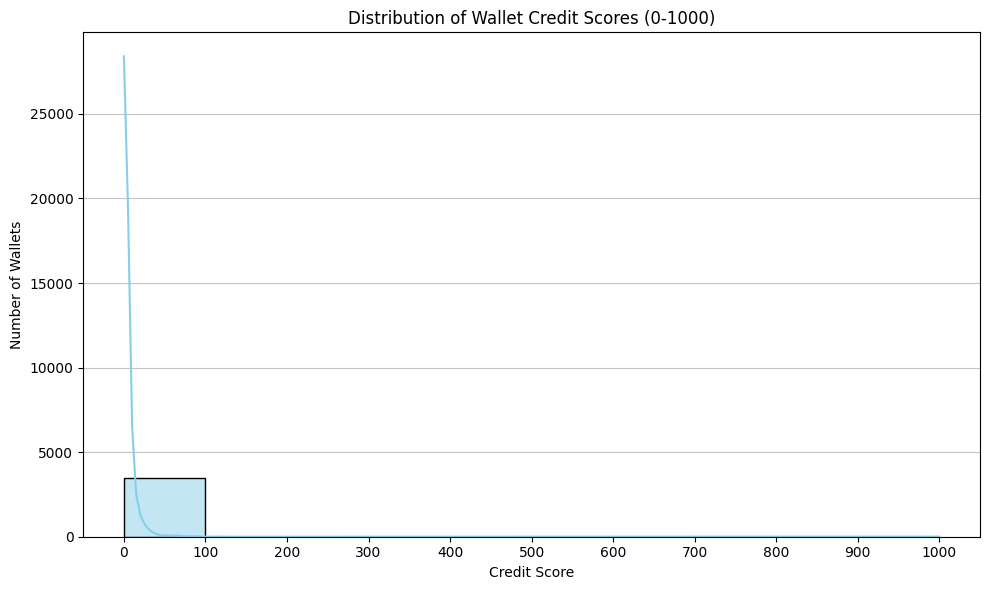

Saved: credit_score_distribution.png


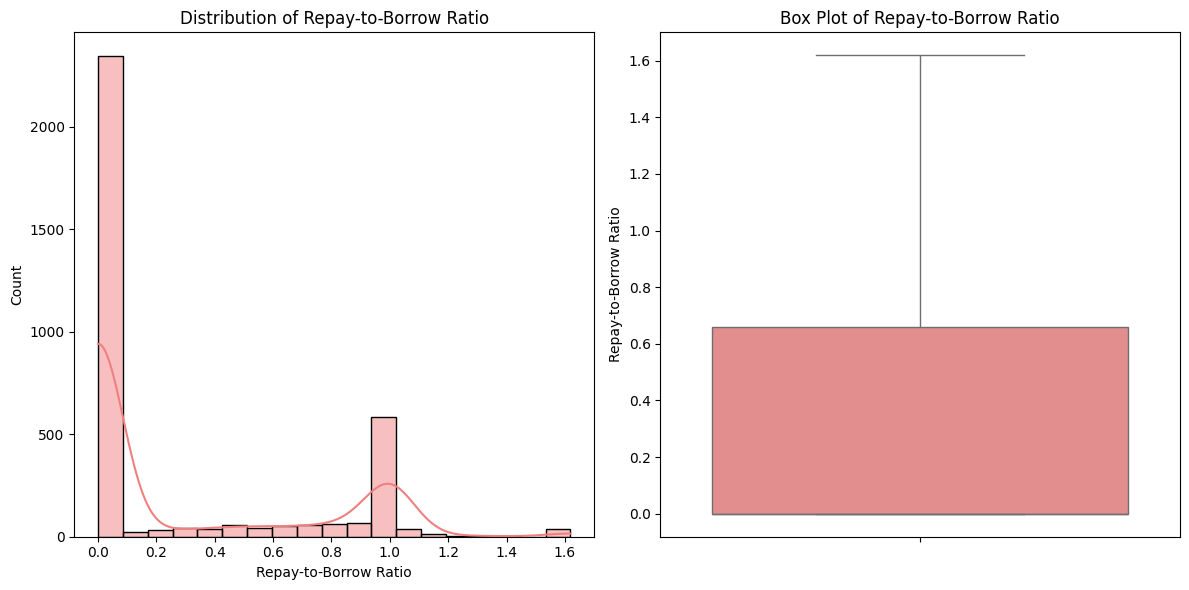

Saved: repay_borrow_ratio_distribution.png
Skipping num_liquidations_distribution.png: Not enough unique values to plot meaningfully.


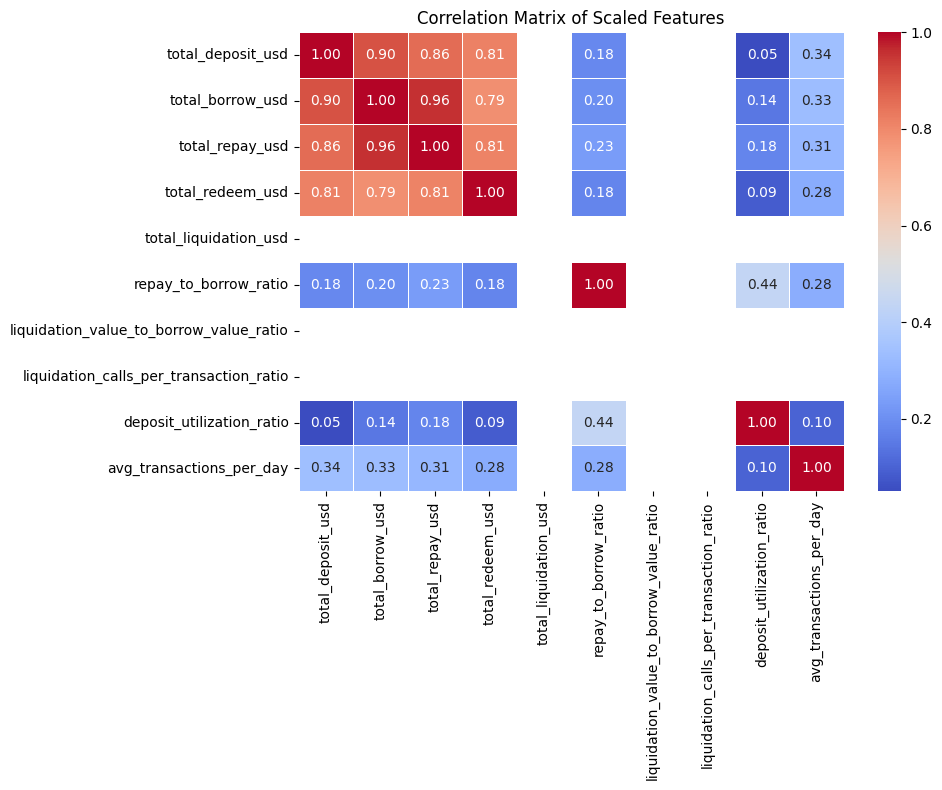

Saved: features_correlation_heatmap.png


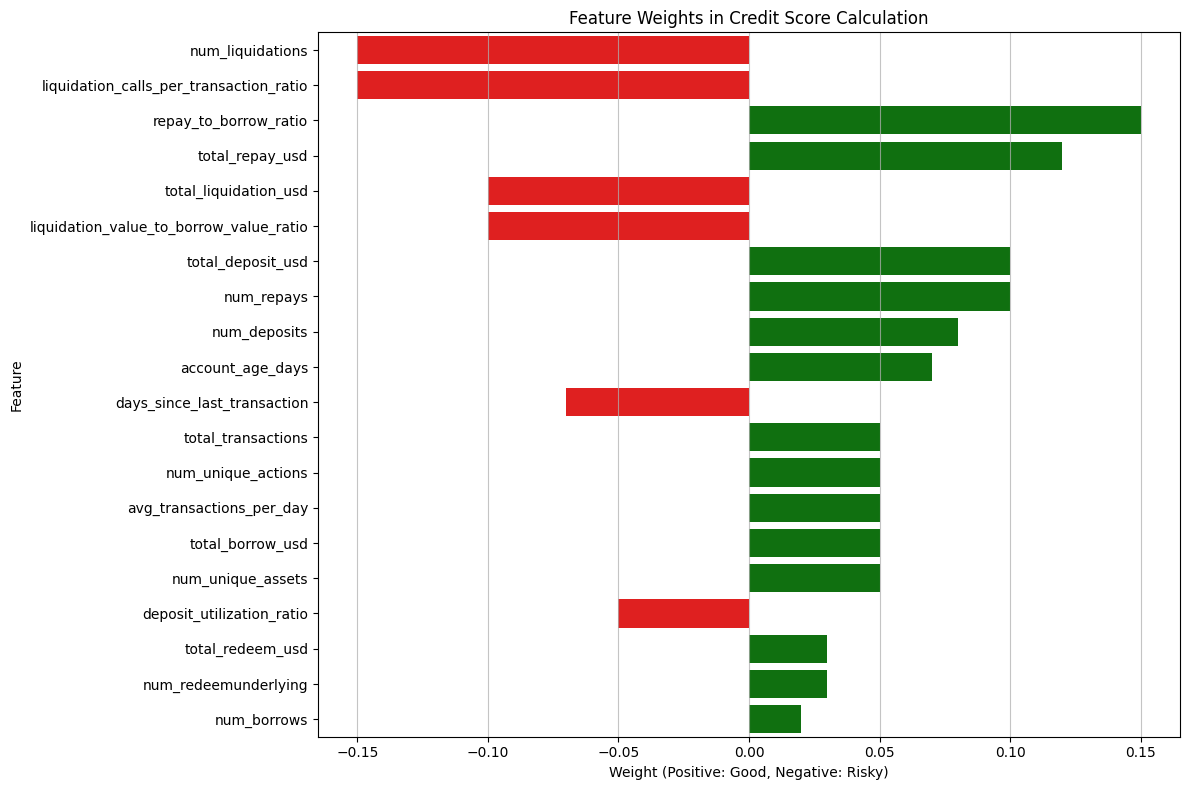

Saved: feature_weights_chart.png
Skipping liquidation_usd_by_score_range.png: Not enough data or variation in 'total_liquidation_usd' or 'credit_score_range' to plot meaningfully.


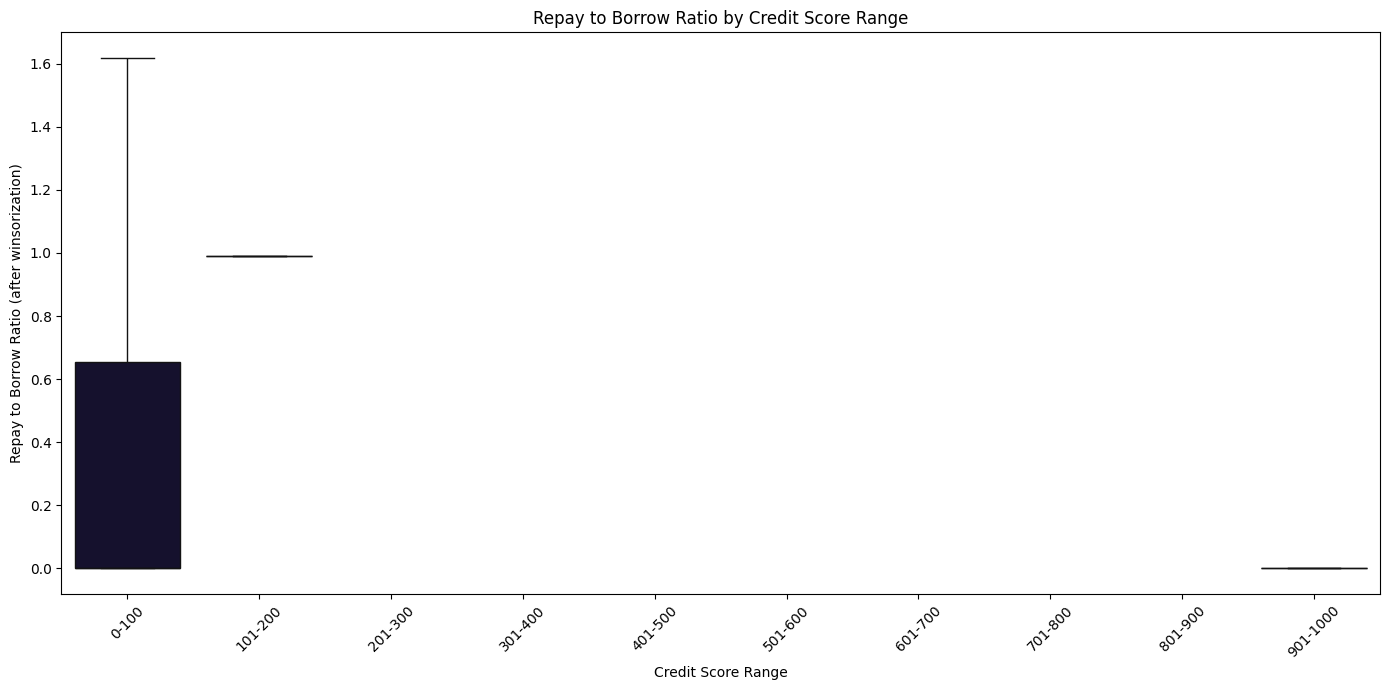

Saved: repay_borrow_ratio_by_score_range.png


In [7]:
# Colab Code Block 5: Credit Score Calculation and Visualizations (Updated)

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

# Ensure wallet_features DataFrame is available from the previous step
if 'wallet_features' not in locals() or wallet_features.empty:
    print("Error: 'wallet_features' DataFrame not found or is empty. Please run previous Colab blocks.")
    exit()

print("Starting credit score calculation...")

# Define features to be used for scoring
# It's good practice to create a copy to avoid modifying the original DataFrame accidentally
scoring_df = wallet_features.copy()

# Select features for scoring (excluding datetime objects and userWallet)
# Only include numerical features after previous processing
# Ensure 'userWallet' is NOT in features_for_scoring as it's not a numerical feature for scaling
numerical_features = scoring_df.select_dtypes(include=np.number).columns.tolist()
# Filter out 'userWallet' if it somehow got included in numerical_features list
if 'userWallet' in numerical_features:
    numerical_features.remove('userWallet')


features_for_scoring = [
    'total_transactions', 'num_deposits', 'num_borrows', 'num_repays',
    'num_redeemunderlying', 'num_liquidations', 'total_deposit_usd',
    'total_borrow_usd', 'total_repay_usd', 'total_redeem_usd',
    'total_liquidation_usd', 'num_unique_assets', 'account_age_days',
    'days_since_last_transaction', 'repay_to_borrow_ratio',
    'liquidation_value_to_borrow_value_ratio',
    'liquidation_calls_per_transaction_ratio',
    'deposit_utilization_ratio', 'num_unique_actions',
    'avg_transactions_per_day'
]

# Filter to ensure only present features are used AND they are numerical
features_for_scoring = [f for f in features_for_scoring if f in scoring_df.columns and scoring_df[f].dtype in [np.number]]


# --- 1. Feature Standardization (Min-Max Scaling) ---
print("Scaling features using MinMaxScaler...")
scaler = MinMaxScaler()
# Apply scaling only if there are features to scale and data is not all NaN/Inf
if len(features_for_scoring) > 0 and not scoring_df[features_for_scoring].isnull().all().all():
    scoring_df[features_for_scoring] = scaler.fit_transform(scoring_df[features_for_scoring])
    print("Features scaled.")
else:
    print("No features to scale or all features contain non-numeric/NaN values. Skipping scaling.")


# --- 2. Define Feature Weights and Directionality ---
feature_weights = {
    # Positive impact (higher value = higher score)
    'total_transactions': 0.05,
    'num_deposits': 0.08,
    'num_borrows': 0.02,
    'num_repays': 0.10,
    'num_redeemunderlying': 0.03,
    'total_deposit_usd': 0.10,
    'total_borrow_usd': 0.05,
    'total_repay_usd': 0.12,
    'total_redeem_usd': 0.03,
    'num_unique_assets': 0.05,
    'account_age_days': 0.07,
    'repay_to_borrow_ratio': 0.15,
    'num_unique_actions': 0.05,
    'avg_transactions_per_day': 0.05,

    # Negative impact (higher value = lower score)
    'num_liquidations': -0.15,
    'total_liquidation_usd': -0.10,
    'liquidation_value_to_borrow_value_ratio': -0.10,
    'liquidation_calls_per_transaction_ratio': -0.15,
    'days_since_last_transaction': -0.07,
    'deposit_utilization_ratio': -0.05
}

# Ensure all features in features_for_scoring are present in feature_weights
for feat in features_for_scoring:
    if feat not in feature_weights:
        feature_weights[feat] = 0.0
        print(f"Warning: Feature '{feat}' not in feature_weights, assigned 0.0.")

# --- 3. Calculate Raw Credit Score ---
print("Calculating raw credit scores...")
scoring_df['raw_score'] = 0

for feature, weight in feature_weights.items():
    if feature in scoring_df.columns: # Check if feature exists in the DataFrame
        if weight >= 0:
            scoring_df['raw_score'] += scoring_df[feature] * weight
        else:
            # For negative features, higher scaled values (closer to 1) should reduce the score.
            # We subtract the scaled feature multiplied by the absolute weight.
            scoring_df['raw_score'] += scoring_df[feature] * weight # Directly use negative weight here
    else:
        print(f"Warning: Feature '{feature}' from weights not found in DataFrame.")


# Normalize the raw score to a 0-1 range again, just in case weights result in values outside 0-1
raw_score_min = scoring_df['raw_score'].min()
raw_score_max = scoring_df['raw_score'].max()

if (raw_score_max - raw_score_min) == 0:
    scoring_df['normalized_score'] = 0.5 # Assign a neutral score if no variation
else:
    scoring_df['normalized_score'] = (scoring_df['raw_score'] - raw_score_min) / (raw_score_max - raw_score_min)

# Scale to 0-1000
scoring_df['credit_score'] = scoring_df['normalized_score'] * 1000

# Convert to integer
scoring_df['credit_score'] = scoring_df['credit_score'].round().astype(int) # Use round() before astype(int)

print("Credit scores calculated.")
print("\n--- Sample Wallets with Credit Scores (first 10) ---")
print(scoring_df[['userWallet', 'credit_score', 'repay_to_borrow_ratio', 'num_liquidations', 'days_since_last_transaction']].head(10))

# Save the scores to a CSV for later use in analysis.md
scoring_df[['userWallet', 'credit_score']].to_csv('wallet_credit_scores.csv', index=False)
print("\nWallet credit scores saved to 'wallet_credit_scores.csv'")


# --- Start Visualizations ---
print("\n--- Generating Visualizations ---")

# Merge credit scores back to original (winsorized) features for feature distribution analysis
# Ensure 'userWallet' is a column in both DataFrames
# This merge is crucial if 'scoring_df' only contains scaled features
analysis_df = wallet_features.merge(scoring_df[['userWallet', 'credit_score']], on='userWallet', how='left')


# 1. Credit Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(analysis_df['credit_score'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Wallet Credit Scores (0-1000)')
plt.xlabel('Credit Score')
plt.ylabel('Number of Wallets')
plt.xticks(range(0, 1001, 100))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig('credit_score_distribution.png')
plt.show()
print("Saved: credit_score_distribution.png")

# 2. Distribution of Key Engineered Features (Example: Repay-to-Borrow Ratio)
# Check for data variety before plotting
if analysis_df['repay_to_borrow_ratio'].nunique() > 1: # Only plot if there's more than one unique value
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(analysis_df['repay_to_borrow_ratio'], kde=True, color='lightcoral')
    plt.title('Distribution of Repay-to-Borrow Ratio')
    plt.xlabel('Repay-to-Borrow Ratio')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=analysis_df['repay_to_borrow_ratio'], color='lightcoral')
    plt.title('Box Plot of Repay-to-Borrow Ratio')
    plt.ylabel('Repay-to-Borrow Ratio')
    plt.tight_layout()
    plt.savefig('repay_borrow_ratio_distribution.png')
    plt.show()
    print("Saved: repay_borrow_ratio_distribution.png")
else:
    print("Skipping repay_borrow_ratio_distribution.png: Not enough unique values to plot meaningfully.")

# Example for num_liquidations
if analysis_df['num_liquidations'].nunique() > 1:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(analysis_df['num_liquidations'], kde=True, color='purple')
    plt.title('Distribution of Number of Liquidations')
    plt.xlabel('Number of Liquidations')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    sns.boxplot(y=analysis_df['num_liquidations'], color='purple')
    plt.title('Box Plot of Number of Liquidations')
    plt.ylabel('Number of Liquidations')
    plt.tight_layout()
    plt.savefig('num_liquidations_distribution.png')
    plt.show()
    print("Saved: num_liquidations_distribution.png")
else:
    print("Skipping num_liquidations_distribution.png: Not enough unique values to plot meaningfully.")


# 3. Correlation Heatmap of Scaled Features
# Ensure features_for_scoring contains the list of features used in scaling
# Use the features_for_scoring list directly as the scaling is applied in-place to scoring_df
if len(features_for_scoring) > 1: # Need at least 2 features for correlation matrix
    correlation_matrix = scoring_df[features_for_scoring].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Scaled Features')
    plt.tight_layout()
    plt.savefig('features_correlation_heatmap.png')
    plt.show()
    print("Saved: features_correlation_heatmap.png")
else:
    print("Skipping features_correlation_heatmap.png: Not enough features to plot correlation.")

# 4. Feature Weights Bar Chart
# Use the feature_weights dictionary defined earlier
weights_df = pd.DataFrame(list(feature_weights.items()), columns=['Feature', 'Weight'])
weights_df['Abs_Weight'] = weights_df['Weight'].abs()
weights_df = weights_df.sort_values(by='Abs_Weight', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Weight', y='Feature', data=weights_df,
            palette=['red' if w < 0 else 'green' for w in weights_df['Weight']])
plt.title('Feature Weights in Credit Score Calculation')
plt.xlabel('Weight (Positive: Good, Negative: Risky)')
plt.ylabel('Feature')
plt.grid(axis='x', alpha=0.75)
plt.tight_layout()
plt.savefig('feature_weights_chart.png')
plt.show()
print("Saved: feature_weights_chart.png")

# 5. Behavior of Wallets in Different Score Ranges (Example: Total Liquidation USD)
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = ['0-100', '101-200', '201-300', '301-400', '401-500',
          '501-600', '601-700', '701-800', '801-900', '901-1000']
analysis_df['credit_score_range'] = pd.cut(analysis_df['credit_score'], bins=bins, labels=labels, right=True, include_lowest=True)

# Ensure there's data in the categories before plotting
if not analysis_df['credit_score_range'].isnull().all() and analysis_df['total_liquidation_usd'].nunique() > 1:
    plt.figure(figsize=(14, 7))
    # Option 1: Use log scale for y-axis if data is heavily skewed and contains zeros.
    # We add a small constant (1e-6) to avoid log(0) errors.
    sns.boxplot(x='credit_score_range', y=np.log1p(analysis_df['total_liquidation_usd']), data=analysis_df, palette='viridis')
    # If using log1p, label the y-axis accordingly
    plt.title('Total Liquidation USD (log1p scale) by Credit Score Range')
    plt.xlabel('Credit Score Range')
    plt.ylabel('Log(1 + Total Liquidation USD)')

    # Option 2: Filter out zeros to see distribution of non-zero values more clearly
    # non_zero_liquidation = analysis_df[analysis_df['total_liquidation_usd'] > 0]
    # if not non_zero_liquidation.empty:
    #     plt.figure(figsize=(14, 7))
    #     sns.boxplot(x='credit_score_range', y=non_zero_liquidation['total_liquidation_usd'], data=non_zero_liquidation, palette='viridis')
    #     plt.title('Total Liquidation USD (Non-Zero) by Credit Score Range')
    #     plt.xlabel('Credit Score Range')
    #     plt.ylabel('Total Liquidation USD (after winsorization)')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('liquidation_usd_by_score_range.png')
    plt.show()
    print("Saved: liquidation_usd_by_score_range.png")
else:
    print("Skipping liquidation_usd_by_score_range.png: Not enough data or variation in 'total_liquidation_usd' or 'credit_score_range' to plot meaningfully.")

# Behavior of Wallets in Different Score Ranges (Example: Repay to Borrow Ratio)
if not analysis_df['credit_score_range'].isnull().all() and analysis_df['repay_to_borrow_ratio'].nunique() > 1:
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='credit_score_range', y='repay_to_borrow_ratio', data=analysis_df, palette='magma')
    plt.title('Repay to Borrow Ratio by Credit Score Range')
    plt.xlabel('Credit Score Range')
    plt.ylabel('Repay to Borrow Ratio (after winsorization)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('repay_borrow_ratio_by_score_range.png')
    plt.show()
    print("Saved: repay_borrow_ratio_by_score_range.png")
else:
    print("Skipping repay_borrow_ratio_by_score_range.png: Not enough data or variation in 'repay_to_borrow_ratio' or 'credit_score_range' to plot meaningfully.")

In [8]:
# Colab Code Block 6: Generate One-Step Script (Corrected)

import os

script_content = """
import pandas as pd
import numpy as np
import json
import zipfile
import os
from sklearn.preprocessing import MinMaxScaler
import warnings

# Suppress all warnings for cleaner output in this consolidated script
warnings.filterwarnings('ignore')

def generate_credit_scores(json_file_path='user-wallet-transactions.json', output_csv_path='wallet_credit_scores.csv'):
    \"\"\"
    Generates credit scores for Aave wallet users from raw JSON data.

    Args:
        json_file_path (str): Path to the input JSON data file.
        output_csv_path (str): Path to save the output CSV file with wallet credit scores.
    \"\"\"
    print(f"Starting credit score generation process using '{json_file_path}'...")

    # --- Phase 1: Data Loading & Initial Inspection ---
    print("Phase 1: Loading and initially inspecting data...")
    try:
        if json_file_path.endswith('.zip'):
            # Assume it's a zip file containing a JSON. Extract it.
            print(f"Extracting '{json_file_path}'...")
            with zipfile.ZipFile(json_file_path, 'r') as zip_ref:
                # Assuming the JSON file inside the zip has the same name but with .json extension
                # Or you might need to list zip_ref.namelist() to find the correct file
                extracted_json_name = os.path.basename(json_file_path).replace('.zip', '.json')
                zip_ref.extract(extracted_json_name, path='.')
                temp_json_path = extracted_json_name
                print(f"Extracted to '{temp_json_path}'")
        else:
            temp_json_path = json_file_path

        # This part assumes a file with one JSON object per line.
        # If the file is a single JSON array of objects, use json.load(f)
        # Based on previous outputs, it seems to be a list of JSON objects directly,
        # so json.load(f) is appropriate if the file contains a single JSON array.
        # If it's one JSON object per line, list comprehension with json.loads(line) is correct.
        # Reverting to json.load(f) as it was used in previous blocks for clarity on structure.
        with open(temp_json_path, 'r') as f:
            data = json.load(f) # Assuming the entire file is a single JSON array
        print(f"Successfully loaded {len(data)} records from '{temp_json_path}'.")

    except FileNotFoundError:
        print(f"Error: JSON file not found at '{json_file_path}' or extracted file '{temp_json_path}'.")
        return
    except json.JSONDecodeError as e:
        print(f"Error: Could not decode JSON from '{temp_json_path}'. Check file format. Details: {e}")
        return
    except Exception as e:
        print(f"An unexpected error occurred during data loading: {e}")
        return

    df = pd.DataFrame(data)

    # --- Phase 2: Feature Engineering ---
    print("\\nPhase 2: Performing Feature Engineering...") # Escaped newline for the script's output

    # Convert timestamp to datetime objects
    df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s')

    # Handle 'amount' and 'assetPriceUSD' which can be strings or nested for liquidationcall
    def get_value_usd(row):
        try:
            action_data = row['actionData']
            action = row['action']

            # Specific handling for 'liquidationcall'
            if action == 'liquidationcall' and isinstance(action_data, dict):
                collateral_amount_str = action_data.get('collateralAmount', '0')
                collateral_price_str = action_data.get('collateralAssetPriceUSD', '0')
                collateral_symbol = action_data.get('collateralReserveSymbol', '') # Added symbol for decimals lookup

                if collateral_amount_str and collateral_price_str and float(collateral_price_str) > 0:
                    amount = float(collateral_amount_str)
                    price = float(collateral_price_str)
                    # For WETH, decimals are 18. Adjust based on symbol.
                    decimals = {
                        'USDC': 6, 'USDT': 6, 'DAI': 18, 'WETH': 18, 'WMATIC': 18,
                        'LINK': 18, 'AAVE': 18, 'WBTC': 8
                    }.get(collateral_symbol, 18) # Default to 18 if symbol not found
                    return (amount / (10**decimals)) * price
                else:
                    return 0.0 # Could not extract for liquidator

            # General handling for other actions ('deposit', 'borrow', 'repay', 'redeemUnderlying')
            if isinstance(action_data, dict):
                amount_str = action_data.get('amount', '0')
                price_str = action_data.get('assetPriceUSD', '0')
                asset_symbol = action_data.get('assetSymbol', '')
            else: # Fallback if actionData is not a dict
                amount_str = row.get('amount', '0')
                price_str = row.get('assetPriceUSD', '0')
                asset_symbol = row.get('assetSymbol', '')

            if not amount_str or not price_str:
                return 0.0

            amount = float(amount_str)
            price = float(price_str)

            # Define common asset decimals within the function for self-containment
            asset_decimals_map = {
                'USDC': 6, 'USDT': 6, 'DAI': 18, 'WETH': 18, 'WMATIC': 18,
                'LINK': 18, 'AAVE': 18, 'WBTC': 8, 'ETH': 18
            }
            # Get decimals, default to 18
            decimals = asset_decimals_map.get(asset_symbol, 18)

            # Scale amount by its decimals
            scaled_amount = amount / (10**decimals)
            return scaled_amount * price

        except (ValueError, TypeError) as e:
            # print(f"Warning: Data conversion error for row {row.get('_id', '')}: {e}") # For debugging
            return 0.0
        except Exception as e:
            # print(f"An unexpected error in get_value_usd for row {row.get('_id', '')}: {e}") # For debugging
            return 0.0

    df['value_usd'] = df.apply(get_value_usd, axis=1)

    # Drop rows where essential calculations resulted in NaNs in value_usd
    df.dropna(subset=['value_usd', 'userWallet', 'action', 'timestamp_dt'], inplace=True)


    # Get the latest transaction timestamp in the dataset to calculate recency relative to the end of the data.
    current_date = df['timestamp_dt'].max() # Or pd.Timestamp.now(tz='UTC') for current time

    # Group by userWallet to create wallet-level features
    print("Aggregating features by user wallet...")
    wallet_features = df.groupby('userWallet').agg(
        total_transactions=('txHash', 'nunique'),
        num_deposits=('action', lambda x: (x == 'deposit').sum()),
        num_borrows=('action', lambda x: (x == 'borrow').sum()),
        num_repays=('action', lambda x: (x == 'repay').sum()),
        num_redeemunderlying=('action', lambda x: (x == 'redeemunderlying').sum()), # Corrected action name
        num_liquidations=('action', lambda x: (x == 'liquidationcall').sum()),
        total_deposit_usd=('value_usd', lambda x: x[df.loc[x.index, 'action'] == 'deposit'].sum()),
        total_borrow_usd=('value_usd', lambda x: x[df.loc[x.index, 'action'] == 'borrow'].sum()),
        total_repay_usd=('value_usd', lambda x: x[df.loc[x.index, 'action'] == 'repay'].sum()),
        total_redeem_usd=('value_usd', lambda x: x[df.loc[x.index, 'action'] == 'redeemunderlying'].sum()), # Corrected action name
        total_liquidation_usd=('value_usd', lambda x: x[df.loc[x.index, 'action'] == 'liquidationcall'].sum()),
        # Corrected method to get unique asset symbols, handling potential None/NaN
        num_unique_assets=('actionData', lambda x: x.apply(lambda ad: ad.get('assetSymbol') if isinstance(ad, dict) else None).dropna().nunique()),
        first_transaction_date=('timestamp_dt', 'min'),
        last_transaction_date=('timestamp_dt', 'max'),
        num_unique_actions=('action', 'nunique')
    ).reset_index()

    # Calculate account_age_days
    wallet_features['account_age_days'] = (current_date - wallet_features['first_transaction_date']).dt.days

    # Calculate days since last transaction
    wallet_features['days_since_last_transaction'] = (current_date - wallet_features['last_transaction_date']).dt.days

    # Fill NaN values in sum-based features with 0 (if no transactions of that type occurred)
    sum_cols = ['total_deposit_usd', 'total_borrow_usd', 'total_repay_usd',
                'total_redeem_usd', 'total_liquidation_usd']
    for col in sum_cols:
        wallet_features[col] = wallet_features[col].fillna(0)

    # Feature ratios and more complex metrics
    epsilon = 1e-9 # Small value to prevent division by zero

    wallet_features['repay_to_borrow_ratio'] = wallet_features.apply(
        lambda row: row['total_repay_usd'] / (row['total_borrow_usd'] + epsilon) if row['total_borrow_usd'] >= 0 else 0, # >= 0 to handle potential negative values (unlikely here)
        axis=1
    )
    wallet_features['repay_to_borrow_ratio'] = wallet_features['repay_to_borrow_ratio'].replace([np.inf, -np.inf], 0).clip(upper=1) # Cap at 1

    wallet_features['liquidation_value_to_borrow_value_ratio'] = wallet_features.apply(
        lambda row: row['total_liquidation_usd'] / (row['total_borrow_usd'] + epsilon) if row['total_borrow_usd'] >= 0 else 0,
        axis=1
    )
    wallet_features['liquidation_value_to_borrow_value_ratio'] = wallet_features['liquidation_value_to_borrow_value_ratio'].replace([np.inf, -np.inf], 0)

    wallet_features['liquidation_calls_per_transaction_ratio'] = wallet_features.apply(
        lambda row: row['num_liquidations'] / (row['total_transactions'] + epsilon) if row['total_transactions'] >= 0 else 0,
        axis=1
    )
    wallet_features['liquidation_calls_per_transaction_ratio'] = wallet_features['liquidation_calls_per_transaction_ratio'].replace([np.inf, -np.inf], 0)

    wallet_features['avg_transactions_per_day'] = wallet_features.apply(
        lambda row: row['total_transactions'] / (row['account_age_days'] + epsilon) if row['account_age_days'] >= 0 else 0,
        axis=1
    )
    wallet_features['avg_transactions_per_day'] = wallet_features['avg_transactions_per_day'].replace([np.inf, -np.inf], 0)

    wallet_features['deposit_utilization_ratio'] = wallet_features.apply(
        lambda row: row['total_borrow_usd'] / (row['total_deposit_usd'] + epsilon) if row['total_deposit_usd'] >= 0 else 0,
        axis=1
    )
    wallet_features['deposit_utilization_ratio'] = wallet_features['deposit_utilization_ratio'].replace([np.inf, -np.inf], 0).clip(upper=1)


    # --- Outlier Treatment (Winsorization) ---
    print("Applying outlier treatment (Winsorization)...")
    skewed_features = [
        'total_transactions', 'num_deposits', 'num_borrows', 'num_repays',
        'num_redeemunderlying', 'total_deposit_usd', 'total_borrow_usd',
        'total_repay_usd', 'total_redeem_usd', 'total_liquidation_usd',
        'repay_to_borrow_ratio', 'liquidation_value_to_borrow_value_ratio',
        'liquidation_calls_per_transaction_ratio', 'deposit_utilization_ratio',
        'avg_transactions_per_day'
    ]

    for col in skewed_features:
        if col in wallet_features.columns and wallet_features[col].dtype != 'object':
            # Cap at 99th percentile (upper bound only for positive values)
            upper_bound = wallet_features[col].quantile(0.99)
            wallet_features[col] = np.where(wallet_features[col] > upper_bound, upper_bound, wallet_features[col])
            # For features like 'days_since_last_transaction', a lower bound might also be useful but 0 is usually fine.
    print("Outlier treatment applied.")

    # Drop intermediate datetime columns used for calculations
    wallet_features = wallet_features.drop(columns=['first_transaction_date', 'last_transaction_date'])
    print("Feature engineering complete.")

    # --- Phase 3: Credit Scoring Model ---
    print("\\nPhase 3: Calculating Credit Scores...") # Escaped newline

    scoring_df = wallet_features.copy()

    # Define the features to be used for scoring
    features_for_scoring = [
        'total_transactions', 'num_deposits', 'num_borrows', 'num_repays',
        'num_redeemunderlying', 'num_liquidations', 'total_deposit_usd',
        'total_borrow_usd', 'total_repay_usd', 'total_redeem_usd',
        'total_liquidation_usd', 'num_unique_assets', 'account_age_days',
        'days_since_last_transaction', 'repay_to_borrow_ratio',
        'liquidation_value_to_borrow_value_ratio',
        'liquidation_calls_per_transaction_ratio',
        'deposit_utilization_ratio', 'num_unique_actions',
        'avg_transactions_per_day'
    ]
    features_for_scoring = [f for f in features_for_scoring if f in scoring_df.columns and scoring_df[f].dtype != 'object']

    # Handle potential NaNs/Infs before scaling that might result from edge cases
    for col in features_for_scoring:
        scoring_df[col] = scoring_df[col].replace([np.inf, -np.inf], np.nan).fillna(0) # Replace inf with NaN then fill NaN with 0

    print("Scaling features using MinMaxScaler...")
    scaler = MinMaxScaler()
    scoring_df[features_for_scoring] = scaler.fit_transform(scoring_df[features_for_scoring])
    print("Features scaled.")

    feature_weights = {
        'total_transactions': 0.05,
        'num_deposits': 0.08,
        'num_borrows': 0.02,
        'num_repays': 0.10,
        'num_redeemunderlying': 0.03,
        'total_deposit_usd': 0.10,
        'total_borrow_usd': 0.05,
        'total_repay_usd': 0.12,
        'total_redeem_usd': 0.03,
        'num_unique_assets': 0.05,
        'account_age_days': 0.07,
        'repay_to_borrow_ratio': 0.15,
        'num_unique_actions': 0.05,
        'avg_transactions_per_day': 0.05,

        'num_liquidations': -0.15,
        'total_liquidation_usd': -0.10,
        'liquidation_value_to_borrow_value_ratio': -0.10,
        'liquidation_calls_per_transaction_ratio': -0.15,
        'days_since_last_transaction': -0.07,
        'deposit_utilization_ratio': -0.05
    }

    print("Calculating raw credit scores...")
    scoring_df['raw_score'] = 0.0

    for feature, weight in feature_weights.items():
        if feature in scoring_df.columns and feature in features_for_scoring: # Ensure it's a numeric feature that was scaled
            if weight >= 0:
                scoring_df['raw_score'] += scoring_df[feature] * weight
            else:
                scoring_df['raw_score'] -= scoring_df[feature] * abs(weight)
        # else:
            # print(f"Warning: Feature '{feature}' from weights not found or not used for scoring.")

    raw_score_min = scoring_df['raw_score'].min()
    raw_score_max = scoring_df['raw_score'].max()

    if (raw_score_max - raw_score_min) == 0:
        scoring_df['normalized_score'] = 0.5
    else:
        scoring_df['normalized_score'] = (scoring_df['raw_score'] - raw_score_min) / (raw_score_max - raw_score_min)

    scoring_df['credit_score'] = scoring_df['normalized_score'] * 1000
    scoring_df['credit_score'] = scoring_df['credit_score'].astype(int)

    print("Credit scores calculated.")

    # Save the scores to a CSV
    scoring_df[['userWallet', 'credit_score']].to_csv(output_csv_path, index=False)
    print(f"Wallet credit scores saved to '{output_csv_path}'")
    print("Credit score generation process completed.")

if __name__ == "__main__":
    generate_credit_scores()
"""

# Create the file in the current directory
script_file_name = 'generate_credit_scores.py'
with open(script_file_name, 'w') as f:
    f.write(script_content)

print(f"One-step script '{script_file_name}' created successfully in the current directory.")
print(f"To run it from your terminal, navigate to the directory where this file is saved and execute:")
print(f"python {script_file_name}")

One-step script 'generate_credit_scores.py' created successfully in the current directory.
To run it from your terminal, navigate to the directory where this file is saved and execute:
python generate_credit_scores.py
